In [75]:
import meshcat
from utils import *
from interface import ExoSkeletonUDPInterface
import time 
import collections


from estimation_problem import solve_estimation_problem
from utils import ArmMeasurementCurrent
from arm_model import create_arm
from reaching_problem import solve_reaching_problem
from pinocchio.visualize import MeshcatVisualizer as Visualizer
import pinocchio as pin

import vicon_sdk_cpp
from vicon_sdk_cpp import ViconClient, ViconFrame


In [2]:
# Connect to the server using a ViconClient.
client = ViconClient()
client.initialize("172.24.117.119:801")
client.run()

# Create a frame to hold the received data.
base_frame = ViconFrame()
target_frame = ViconFrame()

Connecting to Vicon 172.24.117.119:801... 
Connected to Vicon System.
Warning this thread is not going to be real time.


In [3]:
interface = ExoSkeletonUDPInterface()
counter = 0
interface.calibrate()

calibration ...
setting offset ...
finished calibration ...


In [76]:
rmodel, rdata, gmodel, cmodel = create_arm()
viz = Visualizer(rmodel, gmodel, cmodel)
viz.initViewer(open=True)
viz.loadViewerModel()
viz.initializeFrames()
viz.display_frames = True

add_frame("hand", viz.viewer)
add_frame("shoulder", viz.viewer)
add_frame("target", viz.viewer)


viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7013/static/


In [77]:
names = ['hand', 'base', 'shoulder']
data_offset = []
offset = [pin.utils.rpyToMatrix(np.pi/2.0, 0, 0), 0]
counter = 0
T = 10
estimate_x0 = np.zeros(rmodel.nq + rmodel.nv)

measurement = collections.deque(maxlen=T)

target = np.array([ 0.40196694,  0.20887781, 0.2389792 ])
offset_shoulder = 0
torque = 0.0
est_error = []
while True:
    # interface.setCommand([0], [0.], [0], [0], [torque])
    time.sleep(0.001)
    # state = interface.getState()
    # print(state["base_acc"], state["shoulder_acc"], state["wrist_acc"])
    base = Rotation.from_quat(state["base_ori"][0]).as_matrix()
    shoulder = Rotation.from_quat(state["shoulder_ori"][0]).as_matrix()
    hand = Rotation.from_quat(state["wrist_ori"][0]).as_matrix()
    client.get_vicon_frame("exoskeleton_base/exoskeleton_base", base_frame)
    client.get_vicon_frame("Cube/Cube", target_frame)
    target = target_frame.se3_pose[:3] - base_frame.se3_pose[0:3]
    target[0] -= 0.10
    if counter < 100:
        data_offset.append([base.T @ shoulder, base.T @ hand])
    elif counter == 100:
        offset[0] = offset[0] @ data_offset[50][0].T
        offset[1] = data_offset[50][1].T
    else:
        update_frame('hand', viz.viewer, offset[1] @ base.T @ hand, [0.5, 0, 0])
        update_frame("shoulder", viz.viewer,   offset[0] @ base.T @ shoulder)
        update_frame("target", viz.viewer,  np.eye(3), target)

        measurement.append(ArmMeasurementCurrent( offset[0] @ base.T @ shoulder, offset[1] @ base.T @ hand))
        if counter > T + 100:
            st = time.time()
            estimate = solve_estimation_problem(measurement, T, rmodel, estimate_x0)
            q,v = estimate.xs[-1][:rmodel.nq], estimate.xs[-1][rmodel.nq:] 

            if counter > 100 and counter < 120:
                offset_shoulder = state["q"] + estimate.xs[-1][1] 
            else:
                estimate.xs[-1][1] += offset_shoulder
            
            viz.display(estimate.xs[-1][:rmodel.nq])
            # estimate_x0 = estimate.xs[-1]
            state["q"] -= offset_shoulder
            print(state["q"]+estimate.xs[-1][1])
            est_error.append(state["q"]+estimate.xs[-1][1])
            if counter > 120:
                st = time.time()
                ddp = solve_reaching_problem1(target, q, rmodel)
                et = time.time()
                # print(et - st)
                # for i in range(len(ddp.xs)):
                #     viz.display(ddp.xs[i][:rmodel.nq])
                # torque = max(0.05,-0.4*ddp.us[1][1])
                torque = 0

                # print(torque,  estimate.xs[-1][1], state["q"], state["motor_q"], state["shoulder_acc"])


    counter += 1


TypeError: 'NoneType' object is not subscriptable

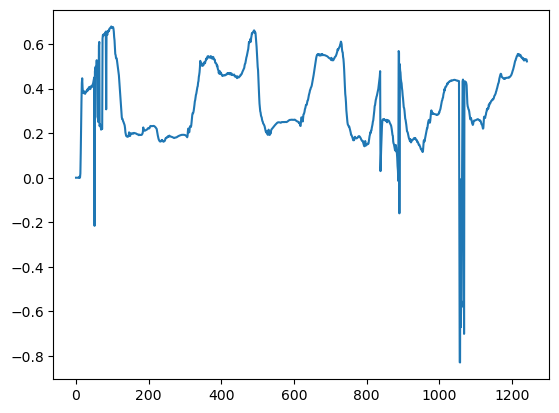

In [72]:
import matplotlib.pyplot as plt
plt.plot(est_error)

In [5]:
## This file contains a simple shooting problem for reaching task of the hand
## This file is based on minimal examples crocoddyl
## Author : Avadesh Meduri
## Date : 29/02/2024

from mim_solvers import SolverSQP, SolverCSQP
import numpy as np
import pinocchio as pin
import crocoddyl


def solve_reaching_problem1(x_des, q0, rmodel):
    rdata = rmodel.createData()
    nq = rmodel.nq; nv = rmodel.nv; nu = nq; nx = nq+nv
    v0 = np.zeros(nv)
    x0 = np.concatenate([q0, v0])
    pin.framesForwardKinematics(rmodel, rdata, q0)
    pin.computeJointJacobians(rmodel, rdata, q0)
    
    
    # # # # # # # # # # # # # # #
    ###  SETUP CROCODDYL OCP  ###
    # # # # # # # # # # # # # # #
    
    # State and actuation model
    state = crocoddyl.StateMultibody(rmodel)
    actuation = crocoddyl.ActuationModelFull(state)
    
    # Running and terminal cost models
    runningCostModel = crocoddyl.CostModelSum(state)
    terminalCostModel = crocoddyl.CostModelSum(state)
    
    
    # Create cost terms 
    # Control regularization cost
    uResidual = crocoddyl.ResidualModelControlGrav(state)
    uRegCost = crocoddyl.CostModelResidual(state, uResidual)
    # State regularization cost
    xResidual = crocoddyl.ResidualModelState(state, x0)
    xRegCost = crocoddyl.CostModelResidual(state, xResidual)
    # endeff frame translation cost
    endeff_frame_id = rmodel.getFrameId("Hand")
    endeff_translation = x_des # move endeff +10 cm along x in WORLD frame
    frameTranslationResidual = crocoddyl.ResidualModelFrameTranslation(state, endeff_frame_id, endeff_translation)
    frameTranslationCost = crocoddyl.CostModelResidual(state, frameTranslationResidual)
    frameVelocityResidual = crocoddyl.ResidualModelFrameVelocity(state, endeff_frame_id, pin.Motion(np.zeros(6)), pin.LOCAL_WORLD_ALIGNED)
    frameVelocityCost = crocoddyl.CostModelResidual(state, frameVelocityResidual)

    # Add costs
    runningCostModel.addCost("stateReg", xRegCost, 1e-1)
    runningCostModel.addCost("ctrlRegGrav", uRegCost, 1e-3)
    runningCostModel.addCost("translation", frameTranslationCost, 0.5)
    terminalCostModel.addCost("stateReg", xRegCost, 1e-1)
    terminalCostModel.addCost("translation", frameTranslationCost, 1e1)
    terminalCostModel.addCost("veloctiy", frameVelocityCost, 1e2)


    # Create Differential Action Model (DAM), i.e. continuous dynamics and cost functions
    running_DAM = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, runningCostModel)
    terminal_DAM = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminalCostModel)
    
    # Create Integrated Action Model (IAM), i.e. Euler integration of continuous dynamics and cost
    dt = 1e-1
    runningModel = crocoddyl.IntegratedActionModelEuler(running_DAM, dt)
    terminalModel = crocoddyl.IntegratedActionModelEuler(terminal_DAM, 0.)
        
    # Create the shooting problem
    T = 10
    problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)
    
    # Create solver + callbacks
    ddp = SolverSQP(problem)
    ddp.setCallbacks([crocoddyl.CallbackLogger()])
    ddp.use_filter_line_search = True
    
    # Warm start : initial state + gravity compensation
    xs_init = [x0 for i in range(T+1)]
    us_init = ddp.problem.quasiStatic(xs_init[:-1])
    
    # Solve
    ddp.solve(xs_init, us_init, maxiter=10)
    
    return ddp

In [47]:
import pinocchio as pin
client.get_vicon_frame("exoskeleton_base/exoskeleton_base", base_frame)
client.get_vicon_frame("Cube/Cube", target_frame)
base_T_vicon = pin.SE3(pin.Quaternion(base_frame.se3_pose[3:]),base_frame.se3_pose[0:3]).inverse()
vicon_T_cube = pin.SE3(pin.Quaternion(target_frame.se3_pose[3:]),target_frame.se3_pose[0:3])

base_T_cube = base_T_vicon*vicon_T_cube
base_T_cube

  R =
-0.0224959  -0.413974   0.910011
 0.0435052   0.908973   0.414578
   -0.9988  0.0489165 -0.0024381
  p =  0.445739  0.865815 0.0773163